In [1]:
import joblib
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn import tree

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH_CONFIG = '../config/config.yaml'
config = yaml.safe_load(open(PATH_CONFIG))

Load all train data and test data

In [3]:
X_train_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['X_train_clean']
y_train_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['y_train_clean']
X_train_clean = joblib.load(X_train_path)
y_train_clean = joblib.load(y_train_path)

X_train_clean_rus_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['X_train_clean_rus']
y_train_clean_rus_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['y_train_clean_rus']
X_train_clean_rus = joblib.load(X_train_clean_rus_path)
y_train_clean_rus = joblib.load(y_train_clean_rus_path)

X_train_clean_ros_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['X_train_clean_ros']
y_train_clean_ros_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['y_train_clean_ros']
X_train_clean_ros = joblib.load(X_train_clean_ros_path)
y_train_clean_ros = joblib.load(y_train_clean_ros_path)

X_test_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['X_test_clean']
y_test_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['y_test_clean']
X_test_clean = joblib.load(X_test_path)
y_test_clean = joblib.load(y_test_path)

**MODELLING**

**Traning Data**

Baseline model

The baseline model used is the most frequent category in the label. In this case, the most frequent category is 0 (Not Fraud), so all the data are predicted 0 (Not Fraud) as visualized in the Confusion Matrix below.

In [4]:
base_model = DummyClassifier(strategy = 'most_frequent')
base_model.fit(X_train_clean, y_train_clean)
y_test_pred = base_model.predict(X_test_clean)

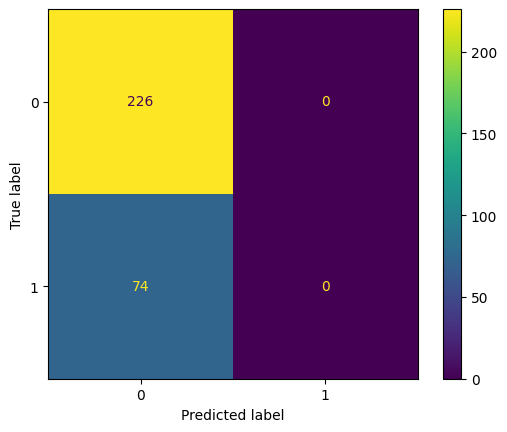

In [5]:
ConfusionMatrixDisplay.from_predictions(y_test_clean, y_test_pred)

plt.show()

Metrics of baseline model

In [6]:
print(classification_report(y_true = y_test_clean,
                            y_pred = y_test_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86       226
           1       0.00      0.00      0.00        74

    accuracy                           0.75       300
   macro avg       0.38      0.50      0.43       300
weighted avg       0.57      0.75      0.65       300



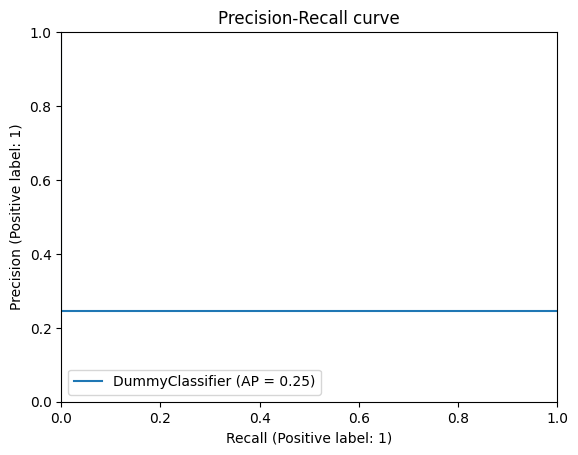

In [7]:
display = PrecisionRecallDisplay.from_estimator(base_model, X_test_clean, y_test_clean)
_ = display.ax_.set_title('Precision-Recall curve')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

Based on this baseline model, the F-1 score 0.43 and the Average Precision value 0.25 are the base metric that will be a reference in the evaluation model later.

Model without tuning

The data have high dimension so that all the model used is tree-based model because this model can selecting the features while the model is trained. Moreover, the data used are non-resampled data, under-sampled data, and over-sampled data.

In [26]:
ls_model = [DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, XGBClassifier]
ls_train_data = {'WithoutResampling': (X_train_clean, y_train_clean),
                 'RandomUnderSampler' : (X_train_clean_rus, y_train_clean_rus), 
                 'RandomOverSampler' : (X_train_clean_ros, y_train_clean_ros)}

In [27]:
df_metriks = pd.DataFrame(columns = ['resampling_method', 'model', 'train_f1_score', 'test_f1_score', 'train_time'])

for key, values in ls_train_data.items():
    for model in ls_model:
        model_ = model(random_state = config['ls_model']['random_state'][0])

        train_time_t0 = time.time()
        model_.fit(values[0], values[1])
        train_time_t1 = time.time()
        train_time = train_time_t1 - train_time_t0

        y_train_pred = model_.predict(values[0])
        train_f1_score = f1_score(y_train_pred, values[1])
        
        y_test_pred = model_.predict(X_test_clean)
        test_f1_score = f1_score(y_test_pred, y_test_clean)
        
        ls_log = pd.DataFrame({'resampling_method': [key], 
                    'model': [model.__name__], 
                    'train_f1_score': [train_f1_score], 
                    'test_f1_score': [test_f1_score],
                    'train_time': [train_time]})
        df_metriks = pd.concat([df_metriks, ls_log], ignore_index=True)

df_metriks = df_metriks.sort_values('test_f1_score', ascending=False).reset_index().drop('index', axis = 1)
df_metriks

,resampling_method,model,train_f1_score,test_f1_score,train_time
0,RandomOverSampler,GradientBoostingClassifier,0.959032,0.760736,0.400543
1,RandomUnderSampler,GradientBoostingClassifier,0.988372,0.729412,0.166836
2,RandomUnderSampler,RandomForestClassifier,1.000000,0.724138,0.131965
3,RandomUnderSampler,XGBClassifier,1.000000,0.703297,0.255345
4,WithoutResampling,GradientBoostingClassifier,0.952941,0.701987,0.287530
5,RandomOverSampler,XGBClassifier,1.000000,0.679487,0.544450
6,RandomUnderSampler,AdaBoostClassifier,0.898551,0.677596,0.079130
7,WithoutResampling,XGBClassifier,1.000000,0.634483,0.505379
8,RandomUnderSampler,DecisionTreeClassifier,1.000000,0.627027,0.019840
9,RandomOverSampler,AdaBoostClassifier,0.888053,0.615385,0.184133


Although all the model above have higher F-1 score in the test dataset than the baseline model but the models are overfitted in the train dataset. So, the models need to hyperparameter tuning to improve the performance.

Cross validation to hyperparameter tuning

In this tuning process using k-fold cross validation, the train dataset used is dataset before pre-processing to avoid data leakage. For each iteration, the validation set will be left as it is while the train set will be pre-processing as the process to get X_train_clean dataset before. In this process, the tuning not just for the hyperparameter, but also the sampler method to see whether the model best perform in non-resampled data or re-sampled data.

In [10]:
X_train_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['X_train']
X_train = joblib.load(X_train_path)

In [11]:
cat_features = config['preprocess']['cat_features']
num_int_features = config['preprocess']['num_int_features']
num_float_features = config['preprocess']['num_float_features']
num_features = config['preprocess']['num_features']

In [12]:
cat_transformer = Pipeline(steps = [('Imputer_nan', SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value='UNKNOWN')),
                                    ('Imputer_cat', SimpleImputer(missing_values='?', strategy='constant', fill_value='UNKNOWN')),
                                    ('OHE', OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features)
    ]
)

In [13]:
ls_model = [DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, XGBClassifier]
ls_params = {
    'dt': {'classifier__criterion': config['ls_model']['dt']['criterion'],
           'classifier__max_depth': config['ls_model']['dt']['max_depth'], 
           'classifier__min_samples_split': config['ls_model']['dt']['min_samples_split'], 
           'classifier__class_weight': config['ls_model']['dt']['class_weight'],
           'classifier__random_state': config['ls_model']['random_state']},
    'rf': {'classifier__n_estimators': config['ls_model']['rf']['n_estimators'], 
           'classifier__min_samples_split': config['ls_model']['rf']['min_samples_split'], 
           'classifier__class_weight': config['ls_model']['rf']['class_weight'],
           'classifier__random_state': config['ls_model']['random_state']},
    'ab': {'classifier__n_estimators': config['ls_model']['ab']['n_estimators'], 
           'classifier__learning_rate': config['ls_model']['ab']['learning_rate'],
           'classifier__random_state': config['ls_model']['random_state']},
    'gb': {'classifier__loss': config['ls_model']['gb']['loss'], 
           'classifier__n_estimators': config['ls_model']['gb']['n_estimators'], 
           'classifier__learning_rate': config['ls_model']['gb']['learning_rate'], 
           'classifier__max_features':config['ls_model']['gb']['max_features'],
           'classifier__random_state': config['ls_model']['random_state']},
    'xgb': {'classifier__max_depth': config['ls_model']['xgb']['max_depth'], 
            'classifier__learning_rate': config['ls_model']['xgb']['learning_rate'], 
            'classifier__sampling_method': config['ls_model']['xgb']['sampling_method'],
            'classifier__random_state': config['ls_model']['random_state']}
}
ls_sampler = [None, RandomUnderSampler, RandomOverSampler]

In [24]:
train_log = pd.DataFrame(columns = ['resampling_method', 'model', 'params', 'train_f1_score', 'test_f1_score', 'train_time'])

for model, params in zip(ls_model, ls_params):
    for sampler in ls_sampler:
        
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model())])
        
        clf = GridSearchCV(estimator = pipeline, param_grid = ls_params[params], cv = 5, scoring = 'f1', return_train_score = True)
        clf.fit(X_train, y_train_clean)
        
        cv_results = pd.DataFrame(clf.cv_results_)
        cv_results = pd.DataFrame(clf.cv_results_)[['params', 'mean_train_score', 'mean_test_score', 'mean_fit_time']]
        cv_results = cv_results.rename(columns = {'mean_train_score': 'train_f1_score',
                                                  'mean_test_score': 'test_f1_score',
                                                  'mean_fit_time': 'train_time'})
        cv_results['model'] = model.__name__
        cv_results['resampling_method'] = sampler.__name__ if sampler != None else 'WithoutResampling'
        train_log = pd.concat([train_log, cv_results], ignore_index = True)

train_log = train_log.sort_values('test_f1_score', ascending = False).reset_index().drop(['index'], axis = 1)
train_log

,resampling_method,model,params,train_f1_score,test_f1_score,train_time
0,WithoutResampling,XGBClassifier,"{'classifier__learning_rate': 0.01, 'classifie...",0.779681,0.723693,0.041517
1,WithoutResampling,XGBClassifier,"{'classifier__learning_rate': 0.01, 'classifie...",0.779681,0.723693,0.041773
2,RandomOverSampler,XGBClassifier,"{'classifier__learning_rate': 0.01, 'classifie...",0.779681,0.723693,0.029660
3,RandomOverSampler,XGBClassifier,"{'classifier__learning_rate': 0.01, 'classifie...",0.779681,0.723693,0.028422
4,RandomUnderSampler,XGBClassifier,"{'classifier__learning_rate': 0.01, 'classifie...",0.779681,0.723693,0.058752
...,...,...,...,...,...,...
265,WithoutResampling,GradientBoostingClassifier,"{'classifier__learning_rate': 0.001, 'classifi...",0.000000,0.000000,0.125763
266,WithoutResampling,GradientBoostingClassifier,"{'classifier__learning_rate': 0.001, 'classifi...",0.000000,0.000000,0.181971
267,RandomUnderSampler,GradientBoostingClassifier,"{'classifier__learning_rate': 0.01, 'classifie...",0.000000,0.000000,0.064200
268,RandomUnderSampler,GradientBoostingClassifier,"{'classifier__learning_rate': 0.001, 'classifi...",0.000000,0.000000,0.188285


In [25]:
best_model = train_log.iloc[train_log[['resampling_method', 'model', 'test_f1_score']].groupby(['resampling_method', 'model']).idxmax()\
                            .loc[:,'test_f1_score']]\
                            .sort_values('test_f1_score', ascending = False)\
                            .reset_index()\
                            .drop(['index'], axis = 1)
best_model

,resampling_method,model,params,train_f1_score,test_f1_score,train_time
0,RandomOverSampler,XGBClassifier,"{'classifier__learning_rate': 0.01, 'classifie...",0.779681,0.723693,0.029660
1,WithoutResampling,XGBClassifier,"{'classifier__learning_rate': 0.01, 'classifie...",0.779681,0.723693,0.041517
2,RandomUnderSampler,XGBClassifier,"{'classifier__learning_rate': 0.01, 'classifie...",0.779681,0.723693,0.058752
3,RandomUnderSampler,DecisionTreeClassifier,"{'classifier__class_weight': None, 'classifier...",0.767376,0.721210,0.011749
4,WithoutResampling,DecisionTreeClassifier,"{'classifier__class_weight': None, 'classifier...",0.767376,0.721210,0.009231
5,RandomOverSampler,DecisionTreeClassifier,"{'classifier__class_weight': None, 'classifier...",0.767376,0.721210,0.009569
6,RandomUnderSampler,AdaBoostClassifier,"{'classifier__learning_rate': 0.001, 'classifi...",0.652043,0.650090,0.073055
7,RandomOverSampler,AdaBoostClassifier,"{'classifier__learning_rate': 0.01, 'classifie...",0.652043,0.650090,0.111278
8,WithoutResampling,AdaBoostClassifier,"{'classifier__learning_rate': 0.01, 'classifie...",0.652043,0.650090,0.108528
9,WithoutResampling,GradientBoostingClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.992743,0.633084,0.175811


Above is the best hyperparameter for every model and sampling method, some model can handle overfit in the model before but some are still overfit in the train dataset. With this hyperparameter, all models will be evaluating to decide the best model using the test dataset.

**Evaluation Model**

In [41]:
columns = ['resampling_method', 'model', 'params', 'train_f1_score', 'test_f1_score', 'train_time']
evaluation_metrics = pd.DataFrame(columns = columns)

for model in ls_model:
    for sampler in ls_sampler:
        i = best_model[best_model['model'] == model.__name__].index.values[0]
        
        param = {key[12:]:value for (key, value) in best_model.iloc[i].params.items()}
        clf = model(**param)
        
        if sampler == None:
            resampling_method = 'WithoutResampling'
            X_train_eval = X_train_clean
            y_train_eval = y_train_clean

        elif sampler == RandomUnderSampler:
            resampling_method = RandomUnderSampler.__name__
            X_train_eval = X_train_clean_rus
            y_train_eval = y_train_clean_rus

        elif sampler == RandomOverSampler:
            resampling_method = RandomOverSampler.__name__
            X_train_eval = X_train_clean_ros
            y_train_eval = y_train_clean_ros

        else:
            assert ValueError(f"There's no {best_model.iloc[i]['resampling_method']} resampling method in the list")
        
        train_time_t0 = time.time()
        clf.fit(X_train_eval, y_train_eval)
        train_time_t1 = time.time()
        train_time = train_time_t1 - train_time_t0
        
        y_train_pred = clf.predict(X_train_clean)
        y_test_pred = clf.predict(X_test_clean)

        score = {'resampling_method' : [resampling_method],
                 'model': [best_model.iloc[i]['model']],
                 'params': [param],
                 'train_f1_score': [f1_score(y_train_clean, y_train_pred)],
                 'test_f1_score': [f1_score(y_test_clean, y_test_pred)],
                 'train_time': [train_time]
                }
        
        evaluation_metrics = pd.concat([evaluation_metrics, pd.DataFrame(score, columns = columns)], ignore_index = True)

evaluation_metrics = evaluation_metrics.sort_values(['test_f1_score'], ascending=False).reset_index().drop(['index'], axis = 1)
evaluation_metrics

,resampling_method,model,params,train_f1_score,test_f1_score,train_time
0,WithoutResampling,XGBClassifier,"{'learning_rate': 0.01, 'max_depth': 3, 'rando...",0.787565,0.754491,0.179085
1,RandomUnderSampler,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'entropy',...",0.760000,0.752941,0.006659
2,RandomOverSampler,XGBClassifier,"{'learning_rate': 0.01, 'max_depth': 3, 'rando...",0.764268,0.751445,0.597307
3,RandomUnderSampler,XGBClassifier,"{'learning_rate': 0.01, 'max_depth': 3, 'rando...",0.754902,0.739884,0.139144
4,RandomOverSampler,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'entropy',...",0.771574,0.730539,0.011415
5,WithoutResampling,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'entropy',...",0.749380,0.725146,0.011270
6,RandomUnderSampler,RandomForestClassifier,"{'class_weight': 'balanced', 'min_samples_spli...",0.844444,0.720930,0.119195
7,RandomUnderSampler,GradientBoostingClassifier,"{'learning_rate': 0.1, 'loss': 'log_loss', 'ma...",0.852217,0.710059,0.175466
8,RandomOverSampler,GradientBoostingClassifier,"{'learning_rate': 0.1, 'loss': 'log_loss', 'ma...",0.982955,0.701299,0.246454
9,WithoutResampling,GradientBoostingClassifier,"{'learning_rate': 0.1, 'loss': 'log_loss', 'ma...",0.994186,0.652482,0.231954


Based on the table above, DecisionTreeClassifier and XGBClassifier are models with higher F-1 score, but considering the fit time, DecisionTreeClassifier takes the training process faster than XGBClassifier. So, decided DecisionTreeClassifer is the final model in this case.

In [43]:
i = best_model[best_model['model'] == DecisionTreeClassifier.__name__].index.values[0]
param = {key[12:]:value for (key, value) in best_model.iloc[i].params.items()}
X = X_train_clean if best_model.iloc[i].resampling_method == 'WithoutResampling' \
    else X_train_clean_rus if best_model.iloc[i].resampling_method == 'RandomUnderSampler' \
    else X_train_clean_ros
y = y_train_clean if best_model.iloc[i].resampling_method == 'WithoutResampling' \
    else y_train_clean_rus if best_model.iloc[i].resampling_method == 'RandomUnderSampler' \
    else y_train_clean_ros

final_model = DecisionTreeClassifier(**param)
final_model.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1)

DecisionTreeClassifier best perform with hyperparameter criterion entropy and max_depth 3.

In [45]:
model_path = config['final_model']['model_directory'] + config['final_model']['model_name']

joblib.dump(final_model, model_path)

['../model/Decision_Tree_Classifier.pkl']

From this model and based on the dataset, known that fraud claim can be classified by the incident_severity, insured_hobbies, and insured_education_level.

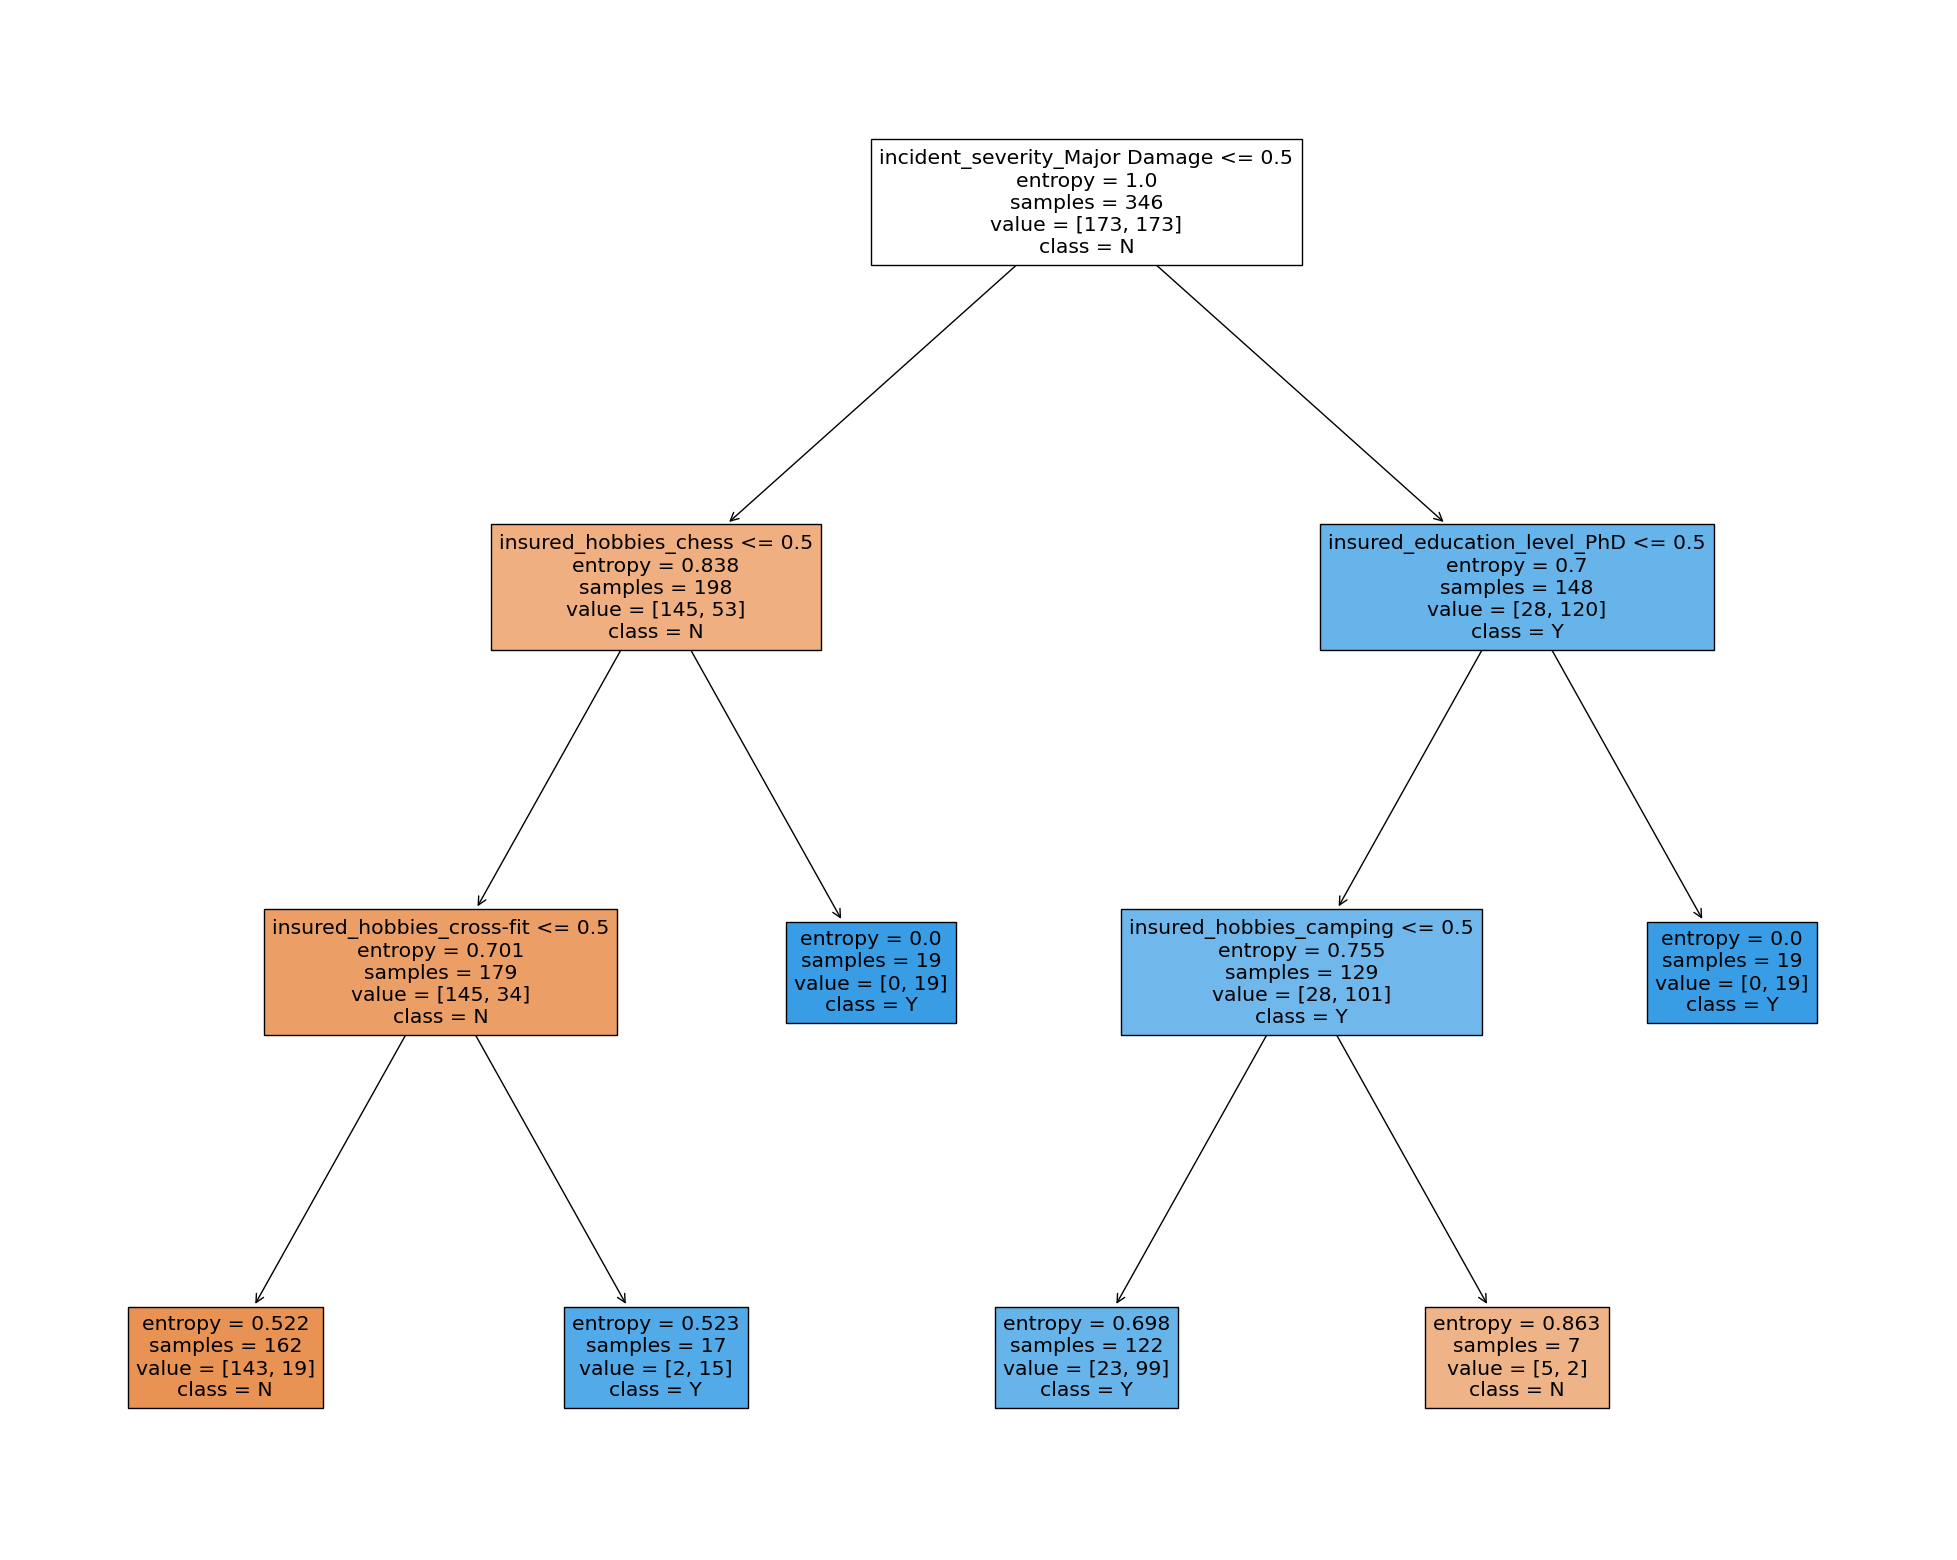

In [44]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(final_model, 
                   feature_names=X_train_clean_rus.columns, 
                   class_names=['N', 'Y'],
                   filled=True)

Predict test dataset

In [48]:
y_test_pred = final_model.predict(X_test_clean)

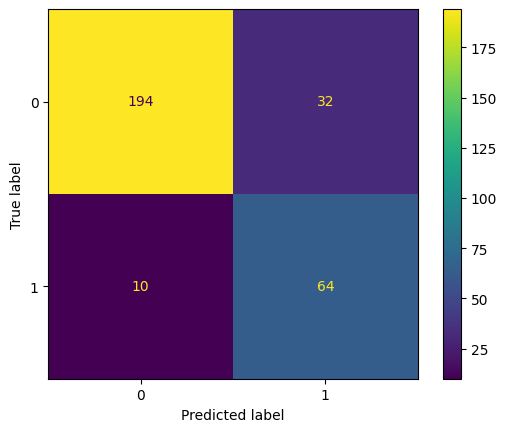

In [52]:
ConfusionMatrixDisplay.from_predictions(y_test_clean, y_test_pred)

plt.show()

Metrics of final model

In [49]:
print(classification_report(y_true = y_test_clean,
                            y_pred = y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       226
           1       0.67      0.86      0.75        74

    accuracy                           0.86       300
   macro avg       0.81      0.86      0.83       300
weighted avg       0.88      0.86      0.87       300



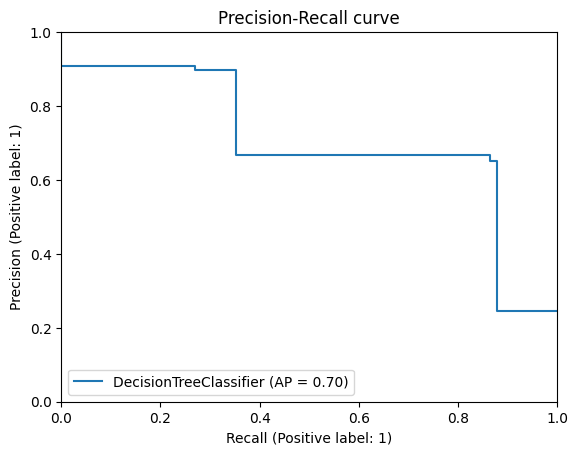

In [50]:
display = PrecisionRecallDisplay.from_estimator(final_model, X_test_clean, y_test_clean)
_ = display.ax_.set_title('Precision-Recall curve')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

Compared to the baseline model, the final model has better performance with F-1 score 0.83 and Average Precision values 0.7. This means the model is pretty good to classify whether a claim is a fraud or not.